# SandBox - Assignment2

## Import libraries

In [53]:
import os
import pyxdf # xdf file importation
import matplotlib.pyplot as plt
import numpy as np
from my_functions import *
# library for creating filters
from scipy.signal import butter, iirnotch, filtfilt, welch
%matplotlib widget


In [54]:
plt.close("all")  # close all figure windows

## Initialization

### File selection and loading

In [55]:
# Define the xdf file path
FILENAME = "001_MolLud_20201112_1_c.xdf"
# FILENAME="020_DesMar_20211129_1_c.xdf"
# path=os.path.normpath("../DAT/Input/001_MolLud_20201112_1_c.xdf")
path = os.path.normpath("DAT/INPUT/"+FILENAME)

### Loading streams of interest

In [56]:
data, header = pyxdf.load_xdf(path, select_streams=[{'type': 'EEG'}, {
                              'type': 'Markers', 'name': 'MouseToNIC'}])

#### Storing the data of interest in two lists (markers and signal) 

In [57]:
# Selection of the streams of interest in the xdf file (data is a list of dictionaries)
for i in range(len(data)):
    print(i)
    if data[i]["info"]["type"] == ['EEG']:
        print(i, "est EEG")
        EEG_Stream = data[i]  # selecting EEG stream
    elif data[i]["info"]["type"] == ['Markers']:
        print(i, "est Marker")
        Mouse_markers_Stream = data[i]  # selecting markers stream

0
0 est EEG
1
1 est Marker


In [58]:
#playing around
print(type(data),"len:",len(data)) #data is a list of dictionaries
print(type(EEG_Stream),"len:",len(EEG_Stream)) #EEG_Stream is a dictionary
print(EEG_Stream.keys())
print(EEG_Stream["time_series"].shape) #Navigate into the dictionary to get to the time series
print(type(Mouse_markers_Stream),"len:",len(Mouse_markers_Stream))

<class 'list'> len: 2
<class 'dict'> len: 4
dict_keys(['info', 'footer', 'time_series', 'time_stamps'])
(221938, 8)
<class 'dict'> len: 4


#### Defining the channels names

In [59]:
# definition of the EEG channels' names
channels_dic = {"Channel_1": "C4",
                "Channel_2": "FC2",
                "Channel_3": "FC6",
                "Channel_4": "CP2",
                "Channel_5": "C3",
                "Channel_6": "FC1",
                "Channel_7": "FC5",
                "Channel_8": "CP1"}

### Shaping recoding parameters' data

In [60]:
Srate = EEG_Stream["info"]["effective_srate"]

# Markers start with a time relative to the execution time of the recording
Marker_times = (
    Mouse_markers_Stream["time_stamps"]-EEG_Stream["time_stamps"][0])

# selecting the marker labels
Markers_labels = Mouse_markers_Stream["time_series"]

# Creation of a 2D array Markers_times_labels: [[markers_timesstamps],[markers_labels]]
Markers_times_labels = np.column_stack((Marker_times, Markers_labels))

# format times_stamps in seconds relative to the execution time of the recording
EEG_times = EEG_Stream["time_stamps"]-EEG_Stream["time_stamps"][0]
# Amplitude of voltage recorded by each electrode of the recording set-up
EEG_raw_amplitudes = EEG_Stream["time_series"]

## Experiments

### Time signal and FFT: raw signal

#### Electrode selection

In [61]:
#Electrode selection [1;8]
i = 1  # electrode number
electrodei = EEG_raw_amplitudes[:, i-1]
print("electrode",str(i),"shape:",electrodei.shape)

electrode 1 shape: (221938,)


#### Plotting electrode i's raw time-signal

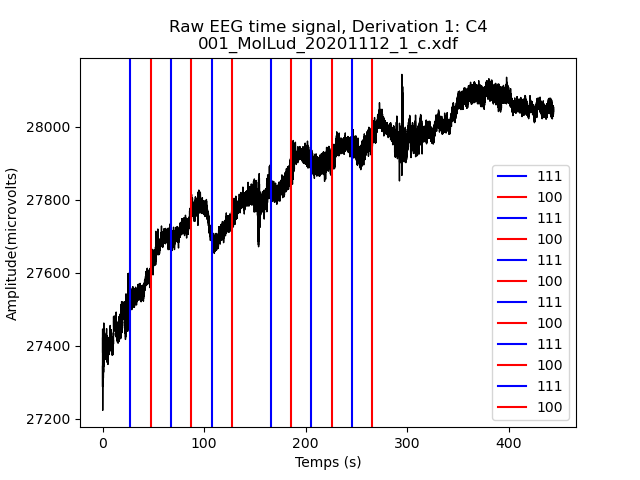

In [62]:
# plotting electrode i-1's signal for verification
single_plot(FILENAME, fig_number=1, x=EEG_times, y=electrodei,
            fig_title="Raw EEG time signal, Derivation " +
            str(i)+": "+channels_dic["Channel_"+str(i)],
            xlabel="Temps (s)", ylabel="Amplitude("+str(EEG_Stream["info"]["desc"][0]["channel"][i-1]["unit"][0])+")",
            markers_times_array=Markers_times_labels)

#### Compute FFT on raw signal

In [63]:
EEG_FFT = compute_fft_on_all_channels(EEG_raw_amplitudes, Srate)
print(type(EEG_FFT),"length:",len(EEG_FFT))


<class 'dict'> length: 2


#### Plotting electrode i's raw signal FFT

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


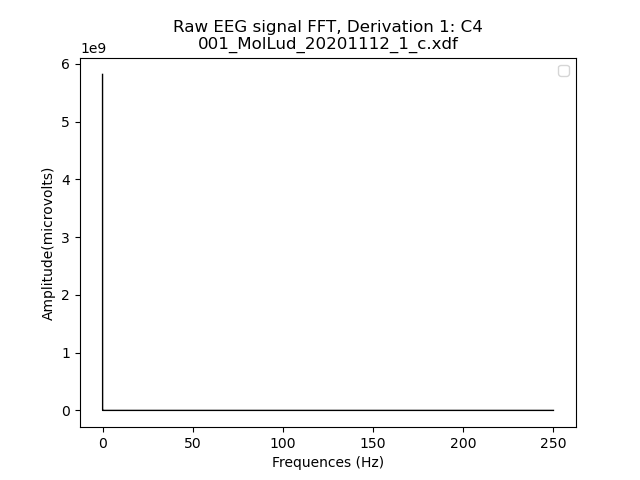

In [64]:
# plotting electrode i-1's FFT for verification
single_plot(FILENAME, fig_number=2, x=EEG_FFT["fft_frequencies"], y=EEG_FFT["FFT_Results_EEG_channels"][:,i],
            fig_title="Raw EEG signal FFT, Derivation " +
            str(i)+": "+channels_dic["Channel_"+str(i)],
            xlabel="Frequences (Hz)", ylabel="Amplitude("+str(EEG_Stream["info"]["desc"][0]["channel"][i-1]["unit"][0])+")")

### Exp 1-Effect of centering on raw Time signals and FFT

#### Center the signal

In [65]:
EEG_raw_amplitudes_centered=EEG_raw_amplitudes-np.mean(EEG_raw_amplitudes,axis=0)

#### Plotting electrode i's centered time-signal

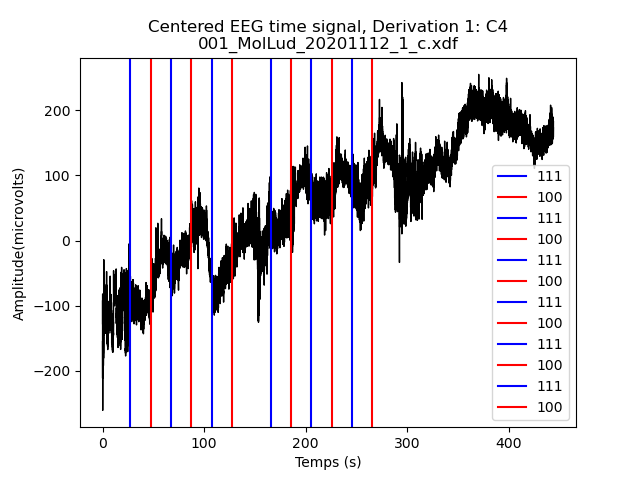

In [66]:
# plotting electrode i-1's centered signal for verification
single_plot(FILENAME, fig_number=3, x=EEG_times, y=EEG_raw_amplitudes_centered[:,i],
            fig_title="Centered EEG time signal, Derivation " +
            str(i)+": "+channels_dic["Channel_"+str(i)],
            xlabel="Temps (s)", ylabel="Amplitude("+str(EEG_Stream["info"]["desc"][0]["channel"][i-1]["unit"][0])+")",
            markers_times_array=Markers_times_labels)

#### Compute FFT on centered signal

In [67]:
EEG_raw_centered_FFT = compute_fft_on_all_channels(EEG_raw_amplitudes_centered, Srate)
print(type(EEG_raw_centered_FFT),"length:",len(EEG_raw_centered_FFT))


<class 'dict'> length: 2


#### Plotting electrode i's centered signal FFT

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


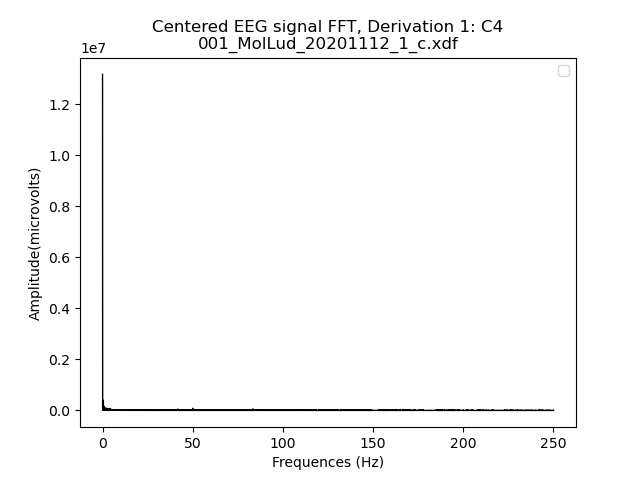

In [68]:
# plotting electrode i-1's centered signal FFT for verification
single_plot(FILENAME, fig_number=4, x=EEG_raw_centered_FFT["fft_frequencies"], y=EEG_raw_centered_FFT["FFT_Results_EEG_channels"][:,i],
            fig_title="Centered EEG signal FFT, Derivation " +
            str(i)+": "+channels_dic["Channel_"+str(i)],
            xlabel="Frequences (Hz)", ylabel="Amplitude("+str(EEG_Stream["info"]["desc"][0]["channel"][i-1]["unit"][0])+")")

### Exp 2-Effect of filtering on raw Time signals and FFT

#### Filtering

In [69]:
#correct cutoff frequencies for butterworth filter
FILTER_ORDER = 4
# corrected cutoff frequency Low-pass butterworth filter
LPf = filtfilt_cutoff_frequency_corrector(
    FILTER_ORDER, 40, Srate, pass_type="low_pass")
# corrected cutoff frequency High-pass butterworth filter
HPf = filtfilt_cutoff_frequency_corrector(
    FILTER_ORDER, 1, Srate, pass_type="high_pass")

In [70]:
# Creation of a 4th order butterworth band pass filter
F_Nyquist = Srate/2
b, a = butter(FILTER_ORDER, [HPf, LPf], btype='bandpass', fs=Srate)

In [71]:
#Filtering the raw signal on all channels
EEG_raw_amplitudes_filtered = filtfilt(b, a, EEG_raw_amplitudes,
                        axis=0)          # Band-pass Filtering

#### Filtered signal : Time-signal

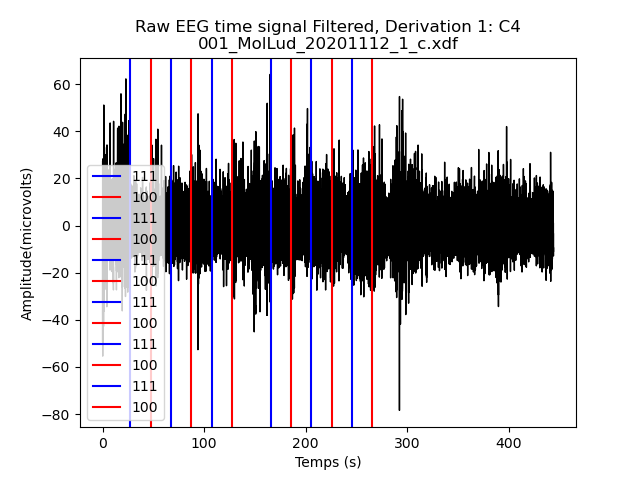

In [72]:
# plotting electrode i-1's signal for verification
single_plot(FILENAME, fig_number=5, x=EEG_times, y=EEG_raw_amplitudes_filtered[:,i],
            fig_title="Raw EEG time signal Filtered, Derivation " +
            str(i)+": "+channels_dic["Channel_"+str(i)],
            xlabel="Temps (s)", ylabel="Amplitude("+str(EEG_Stream["info"]["desc"][0]["channel"][i-1]["unit"][0])+")",
            markers_times_array=Markers_times_labels)

#### Filtered signal : FFT

In [73]:
EEG_raw_amplitudes_filtered_FFT = compute_fft_on_all_channels(EEG_raw_amplitudes_filtered, Srate)
print(type(EEG_raw_amplitudes_filtered_FFT),"length:",len(EEG_raw_amplitudes_filtered_FFT))

<class 'dict'> length: 2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


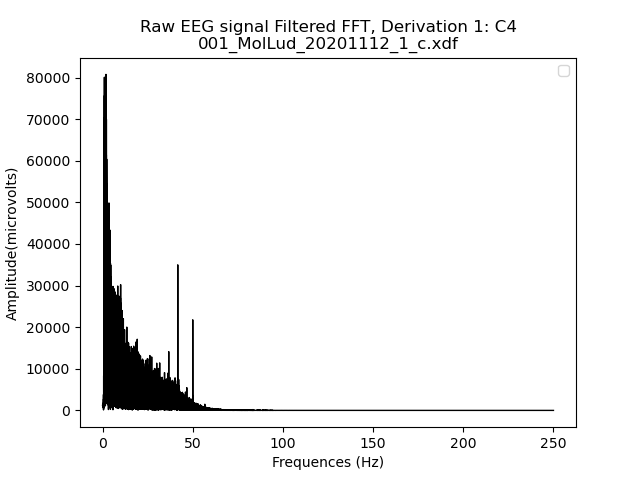

In [74]:
# plotting electrode i-1's FFT for verification
single_plot(FILENAME, fig_number=6, x=EEG_raw_amplitudes_filtered_FFT["fft_frequencies"], y=EEG_raw_amplitudes_filtered_FFT["FFT_Results_EEG_channels"][:,i],
            fig_title="Raw EEG signal Filtered FFT, Derivation " +
            str(i)+": "+channels_dic["Channel_"+str(i)],
            xlabel="Frequences (Hz)", ylabel="Amplitude("+str(EEG_Stream["info"]["desc"][0]["channel"][i-1]["unit"][0])+")")

### Exp 3-Effect of filtering on centered Time signals and FFT

#### Filtering

In [75]:
#Filtering the centered signal on all channels
EEG_raw_amplitudes_centered_filtered = filtfilt(b, a, EEG_raw_amplitudes_centered,axis=0)          # Band-pass Filtering

#### Filtered centered signal : Time-signal

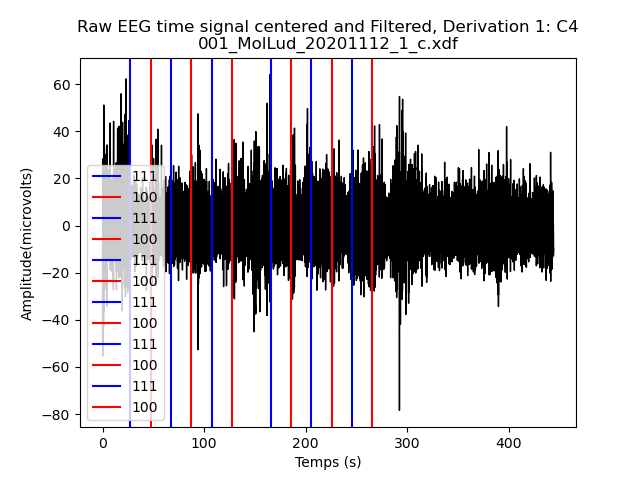

In [76]:
# plotting electrode i-1's signal for verification
single_plot(FILENAME, fig_number=7, x=EEG_times, y=EEG_raw_amplitudes_centered_filtered[:,i],
            fig_title="Raw EEG time signal centered and Filtered, Derivation " +
            str(i)+": "+channels_dic["Channel_"+str(i)],
            xlabel="Temps (s)", ylabel="Amplitude("+str(EEG_Stream["info"]["desc"][0]["channel"][i-1]["unit"][0])+")",
            markers_times_array=Markers_times_labels)

#### Filtered centered signal : FFT

In [77]:
EEG_raw_amplitudes_centered_filtered_FFT = compute_fft_on_all_channels(EEG_raw_amplitudes_centered_filtered, Srate)
print(type(EEG_raw_amplitudes_centered_filtered_FFT),"length:",len(EEG_raw_amplitudes_centered_filtered_FFT))

<class 'dict'> length: 2


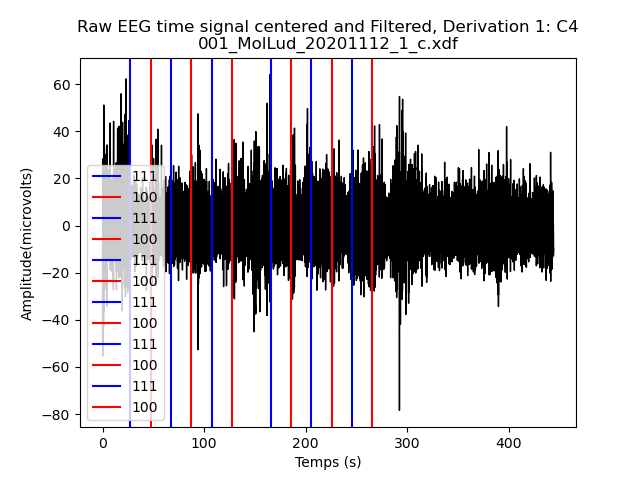

In [78]:
plt.show()